# MRI and Alzheimers 
## BIOF509 Spring 2019 Frinal Project

## Import Dataset

In [ ]:
# This project is trying to find the best method to predict whether the patient will get
# Dementia/Alzheimers or not given the data
# Data should not be combined, each dataset should not be used individually only.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# merge two datasets
# mri_cross = pd.read_csv('oasis_cross-sectional.csv', sep = ',')
mri_long = pd.read_csv('oasis_longitudinal.csv', sep = ',')
mri_long.head()

In [ ]:
# closer look to the score and labels
mri_long.groupby(['CDR', 'Group']).size().unstack()

In [ ]:
mri_long.isnull().sum()

## Pre-Process

In [ ]:
# the data contains more than one visits, we only keep single visit = 1
# no converted patients included
# MR Delay == 0
# df = mri_long.loc[mri_long['Visit'] == 1]
df = mri_long
df = df.drop(['Subject ID', 'MRI ID', 'Hand', 'MR Delay'], axis = 1)
display(df.head(), df.shape)

In [ ]:
# missing values at the initial Visit
# SES (Socioeconomics Status)
df.isnull().sum()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ode = OrdinalEncoder()

# CDR ordinal 
# 0.0(0.0), 0.5(1.0), 1.0(2.0)
cdr = df[["CDR"]]
cdr_code = ode.fit_transform(cdr)
df['CDR_code'] = cdr_code

In [ ]:
# MMSE Scores Mini-Mental State Examination - Ordinal
# Ref: https://www.heartandstroke.ca/-/media/pdf-files/canada/clinical-update/allen-huang-cognitive-screening-toolkit.ashx?la=en&hash=631B35521724C28268D0C2130D07A401E33CDBB0
# 25-30 (Questionably significant); 20-25 (Mild); 10-20 (Moderate); 0-10 (Severe)
def mmse_group(col):
    if col <= 10:
        return "Severe"
    elif 10 < col <= 20:
        return "Moderate"
    elif 20 < col <= 25:
        return "Mild"
    elif 25 < col <= 30:
        return "Questionably significant"
    else:
        return "missing"

def mmse_code(col):
    if col <= 10:
        return "3"
    elif 10 < col <= 20:
        return "2"
    elif 20 < col <= 25:
        return "1"
    elif 25 < col <= 30:
        return "0"
    else:
        return "-1"
df['MMSE Group'] = df['MMSE'].apply(mmse_group)
df['MMSE Group'].value_counts(sort = True)

df['MMSE_code'] = df['MMSE'].apply(mmse_code)
df.head()
# mmse_group = df[["MMSE Group"]]
# mmse_code = ode.fit_transform(mmse_group)
# df['MMSE_code'] = mmse_code
# df.groupby(['MMSE_code', 'MMSE Group']).count()

In [ ]:
from sklearn.preprocessing import LabelEncoder

lbe = LabelEncoder()

# M/F F = 0, M = 1
df['Gender_code'] = lbe.fit_transform(df['M/F'])

# Group Demented = 0, Nondemented = 1
df['Group_code'] = lbe.fit_transform(df['Group'])

In [ ]:
display(df.info(), df.columns)

## Data Exploration

In [ ]:
# Demented > ND at patients' initial visit
sns.countplot(x = 'Group', data = df)

In [ ]:
# converted --> Demented
df['Group'] = df['Group'].replace(['Converted'],['Demented'])
sns.countplot(x = 'Group', data = df)

In [ ]:
sns.countplot(x = 'CDR', data= df)

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


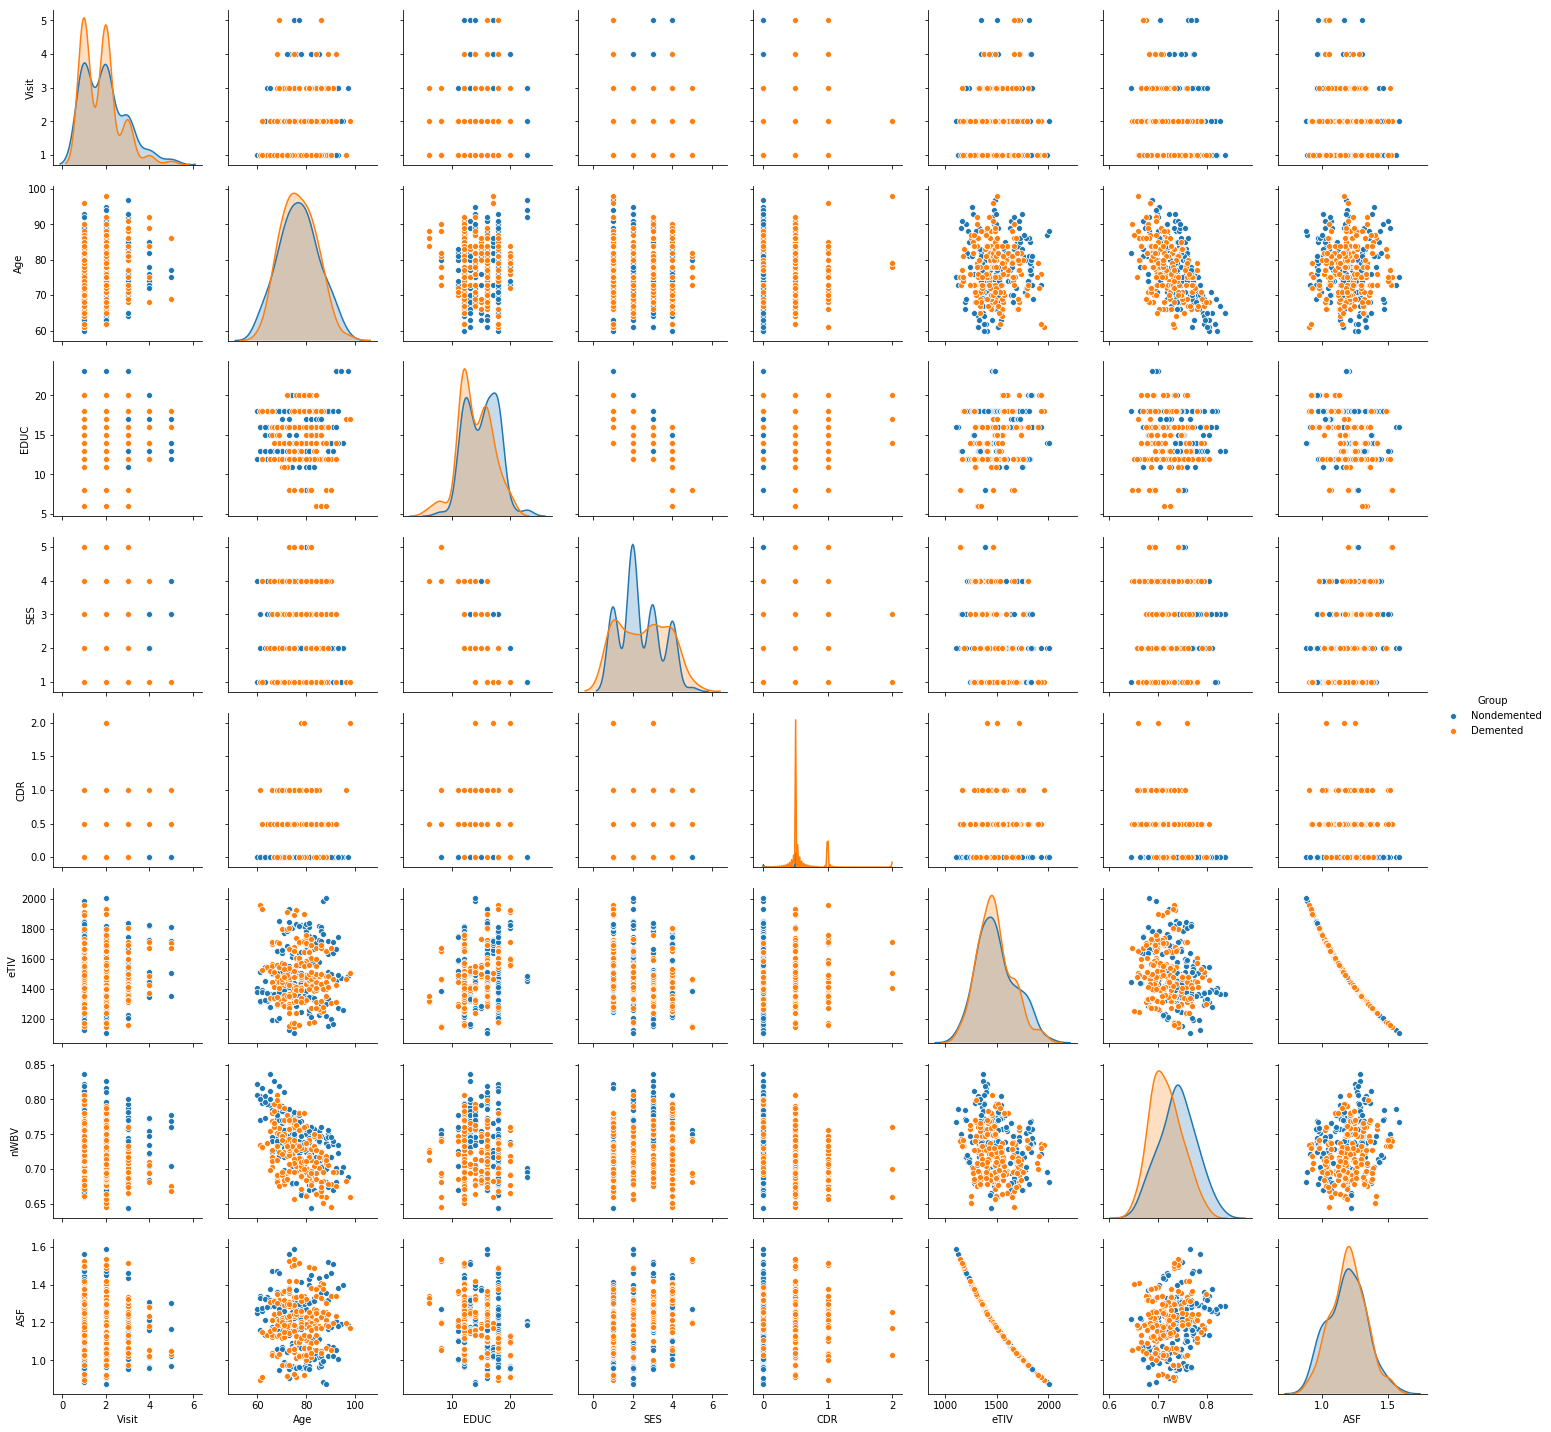

In [23]:
# multicolinearity exists
cols1 = ['Group', 'M/F', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE Group', 'CDR', 'eTIV', 'nWBV','ASF']
df1 = df[cols1]
p1 = sns.pairplot(df1, hue = 'Group')

In [ ]:
# lets see 'Group' relationships with other predictors one by one
# Gender: M/F
# Demented male > ND male ; ND female > Demented female
# female less likely to be Demented than male
sns.countplot(x = 'M/F', hue = 'Group', data = df)

In [ ]:
# Age vs Group
sns.kdeplot(df['Age'], shade = True)

### Remove NA & Impute

In [20]:
# columns included in the analysis
cols2 = ['Group_code', 'Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 
         'MMSE_code', 'CDR_code', 'eTIV', 'nWBV', 'ASF']
df_cd = df[cols2]

# remove NA
df_rmna = df_cd.dropna()

# impute 
# df_ipna = df.

### Normalization

In [ ]:
# recoded categorical varibles (Group_code)
# Group, M/F nominal
# CDR ordinal

cat_cols = ['Group_code', 'Gender_code', 'MMSE_code', 'CDR_code']
num_cols = ['Visit', 'Age', 'EDUC', 'SES', 'eTIV', 'nWBV', 'ASF']

X = 

## Modeling

In [19]:
# decision tree
# random forest
# SVM
# logistic regression
# KNN (handles nonlinearity)
# loss function (measures how good we predict each example, SSE commonly used)
# cost function (loss function for all training examples, MSE)
# minimize cost function by solving an optimize problem
# gradient descent: gradient shows the direction towards the minimum
from sklearn.model_Selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
X_train.shape, y_train_shape

In [ ]:
X_test.shape, y_test.shape

In [ ]:
# Decision Tree 
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth = 5)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
mean_squared_error(y_test, y_predict)


In [ ]:
# Random Forest (bagging)
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
mean_squared_error(y_test, y_predict)

In [ ]:
# Gradient Boosting (boosting)
# sequential improvement of models by training on their errors
# improves errors, one tree each step
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
mean_squared_error(y_test, y_predict)